# Лаба 5: Gradient Boosting

### Let's Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold

In [2]:
import os

# This is my file path for the lab works
os.chdir("C:/Users/bahra/Desktop/ITMO Master's/2nd Semester/АД на Python/Лаба 5")

### Loading the dataset

In [3]:
# Let's read the data
df = pd.read_csv("default of credit card clients.csv", sep = ';')
# Let's see what we have
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default_payment_next_month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  

[5 rows x 25 columns]

### Let's read it by default payment next month
* We have get a clear view of our data

In [4]:
df.groupby(['default_payment_next_month']).count()

ID  LIMIT_BAL    SEX  EDUCATION  MARRIAGE  \
default_payment_next_month                                                 
0                           23364      23364  23364      23364     23364   
1                            6636       6636   6636       6636      6636   

                              AGE  PAY_0  PAY_2  PAY_3  PAY_4  ...  BILL_AMT3  \
default_payment_next_month                                     ...              
0                           23364  23364  23364  23364  23364  ...      23364   
1                            6636   6636   6636   6636   6636  ...       6636   

                            BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
default_payment_next_month                                              
0                               23364      23364      23364     23364   
1                                6636       6636       6636      6636   

                            PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
default_payment_next_month                                                    
0                              23364     23364     23364     23364     23364  
1                               6636      6636      6636      6636      6636  

[2 rows x 24 columns]

## As you can see, our data is not unbalanced. We can draw several conclusions from this: 

* To assess the quality of models, we cannot use accuracy metrics. We will use a score for unbalanced data -- f1 score 
* Since the training of the Gradient Boosting algorithm is affected by the imbalance of the data, we will generate additional data by copying into the training data

In [5]:
X = df.drop(["ID", "default_payment_next_month"], axis=1)
y = df["default_payment_next_month"]

In [6]:
new_df = df.sample(frac=1)

In [7]:
len(new_df)

30000

In [8]:
df_train = new_df[:int(len(new_df) * 0.7)]
df_test = new_df[int(len(new_df) * 0.7):]

In [9]:
df_train.groupby(['default_payment_next_month']).count()

ID  LIMIT_BAL    SEX  EDUCATION  MARRIAGE  \
default_payment_next_month                                                 
0                           16343      16343  16343      16343     16343   
1                            4657       4657   4657       4657      4657   

                              AGE  PAY_0  PAY_2  PAY_3  PAY_4  ...  BILL_AMT3  \
default_payment_next_month                                     ...              
0                           16343  16343  16343  16343  16343  ...      16343   
1                            4657   4657   4657   4657   4657  ...       4657   

                            BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
default_payment_next_month                                              
0                               16343      16343      16343     16343   
1                                4657       4657       4657      4657   

                            PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
default_payment_next_month                                                    
0                              16343     16343     16343     16343     16343  
1                               4657      4657      4657      4657      4657  

[2 rows x 24 columns]

In [10]:
df_test.groupby(['default_payment_next_month']).count()

ID  LIMIT_BAL   SEX  EDUCATION  MARRIAGE   AGE  \
default_payment_next_month                                                     
0                           7021       7021  7021       7021      7021  7021   
1                           1979       1979  1979       1979      1979  1979   

                            PAY_0  PAY_2  PAY_3  PAY_4  ...  BILL_AMT3  \
default_payment_next_month                              ...              
0                            7021   7021   7021   7021  ...       7021   
1                            1979   1979   1979   1979  ...       1979   

                            BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
default_payment_next_month                                              
0                                7021       7021       7021      7021   
1                                1979       1979       1979      1979   

                            PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
default_payment_next_month                                                    
0                               7021      7021      7021      7021      7021  
1                               1979      1979      1979      1979      1979  

[2 rows x 24 columns]

In [11]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month'],
      dtype='object')

In [12]:
df.describe()

ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  default_payment_next_month  
count   30000.000000                30000.000000  
mean     5215.502567                    0.221200  
std     17777.465775                    0.415062  
min         0.000000                    0.000000  
25%       117.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000  

[8 rows x 25 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

### Let's extract data in train

In [14]:
df_1 = df_train[df_train["default_payment_next_month"] == 1]
df_0 = df_train[df_train["default_payment_next_month"] == 0]
df_temp = df_1
m = len(df_0) // len(df_1) 
ost = len(df_0) % len(df_1) 

for i in range(m - 1):
    df_temp = df_temp.append(df_1)
    
df_temp = df_temp.append(df_1.sample(frac=1).head(ost))
df_train = df_temp.append(df_0).sample(frac=1)

C:\Users\bahra\AppData\Local\Temp\ipykernel_9292\343241870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_1)
C:\Users\bahra\AppData\Local\Temp\ipykernel_9292\343241870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_1)
C:\Users\bahra\AppData\Local\Temp\ipykernel_9292\343241870.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_1.sample(frac=1).head(ost))
C:\Users\bahra\AppData\Local\Temp\ipykernel_9292\343241870.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_temp.append(df_0).sample(frac=1)


In [15]:
df_train.groupby(['default_payment_next_month']).count()

ID  LIMIT_BAL    SEX  EDUCATION  MARRIAGE  \
default_payment_next_month                                                 
0                           16343      16343  16343      16343     16343   
1                           16343      16343  16343      16343     16343   

                              AGE  PAY_0  PAY_2  PAY_3  PAY_4  ...  BILL_AMT3  \
default_payment_next_month                                     ...              
0                           16343  16343  16343  16343  16343  ...      16343   
1                           16343  16343  16343  16343  16343  ...      16343   

                            BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
default_payment_next_month                                              
0                               16343      16343      16343     16343   
1                               16343      16343      16343     16343   

                            PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
default_payment_next_month                                                    
0                              16343     16343     16343     16343     16343  
1                              16343     16343     16343     16343     16343  

[2 rows x 24 columns]

## Let's divide the data into train and test sample

In [16]:
X_train = df_train.drop(["ID", "default_payment_next_month"], axis=1)
y_train = df_train["default_payment_next_month"]


X_test = df_test.drop(["ID", "default_payment_next_month"], axis=1)
y_test = df_test["default_payment_next_month"]

## Gradient Boosting

In [17]:
model = GradientBoostingClassifier(random_state=42,
                                    # Percentage of observations in a random subsample for the next tree
                                    subsample=0.66,
                                    # Share of variables in a random subsample for the next tree
                                    max_features='sqrt',
                                    # Number of trees
                                    n_estimators=500,
                                    # quality criterion 'deviance' (cross-entropy) or 'exponential' (as in AdaBoost)
                                    # 'deviance' for classification with output probabilities
                                    loss='deviance',
                                    # shrinkage We multiply each tree by this number.
                                    # It is recommended to set small values from (0, 0.3].
                                    learning_rate=0.01,
                                    # wood pollution is measured by “mse” or “friedman_mse” (mse with improvements)
                                     # "mae" removed from current version,
                                    criterion='friedman_mse',
                                    # minimal pollution reduction
                                    min_impurity_decrease=0.001,
                                    # minimum number of observations in a child node
                                    min_samples_leaf=5,
                                    # minimum number of observations in parent node
                                    min_samples_split=10,
                                    # number of nodes in the tree (in RandomForest otherwise !!!!!!!!!!!!!!!)
                                    max_depth=5,
                                    # how to return intermediate results
                                    verbose=0
                                    # There are other options that reduce the size of the tree,
                                    # same as DecisionTreeClassifier
                                    )

## Grid Search CV with best parameters

In [18]:
params_set = {  
      'n_estimators': [100, 300, 500, 800, 1000],
      'max_depth': [3, 4, 6],
      'learning_rate': [0.05, 0.1, 0.3]
  }

f1 = make_scorer(f1_score, average='weighted')

grid_CV = GridSearchCV(model, param_grid=params_set, cv=2, 
                               #  выбор критерия качества
                               scoring=f1, 
                               #  поведение в случае ошибки при вычислении критерия качества
                               error_score='raise', 
                               #  обучить модель с лучшими значениями параметроы
                               refit=True, 
                               pre_dispatch=None, verbose=0)

gs_result = grid_CV.fit(X_train, y_train)

C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be 

C:\Users\bahra\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


In [19]:
gs_result.best_score_

0.8727777805901802

In [20]:
gs_result.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}

In [21]:
gs_result.best_estimator_

GradientBoostingClassifier(loss='deviance', max_depth=6, max_features='sqrt',
                           min_impurity_decrease=0.001, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=1000,
                           random_state=42, subsample=0.66)

## Train the best model configuration on all training data 

In [22]:
classifier = GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                           min_impurity_decrease=0.001, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=1000,
                           random_state=42, subsample=0.66)

classifier.fit(X_train, y_train)  

GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                           min_impurity_decrease=0.001, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=1000,
                           random_state=42, subsample=0.66)

## Evaluating results

In [23]:
y_pred_train = classifier.predict(X_train)  
y_pred_test = classifier.predict(X_test)  

In [24]:
print(u'Training sample contingency table')
conf_mat = confusion_matrix(y_train, y_pred_train)

# Making beautiful
conf_mat_train = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
conf_mat_train

Training sample contingency table


0      1
0  15936    407
1     43  16300

In [25]:
print('F1 score on training set', f1_score(y_train, y_pred_train, average='weighted'))

F1 score on training set 0.9862309302357584


In [26]:
print(u'Contingency table for test set')
conf_mat = confusion_matrix(y_test, y_pred_test)

# Making beautiful
conf_mat_train = pd.DataFrame(conf_mat, index=classifier.classes_, columns=classifier.classes_)
conf_mat_train

Contingency table for test set


0    1
0  6169  852
1  1035  944

In [27]:
print('F1 score on test set', f1_score(y_test, y_pred_test, average='weighted'))

F1 score on test set 0.7865999933270486


**An important feature of wooden modules is that we can easily analyze the importance of each feature and thus interpret how the models work. This property is the most important advantage of wooden algorithms, since no one needs a black box. We will analyze features using the shap library**

In [28]:
import shap
shap.initjs()

In [31]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test[:1000])

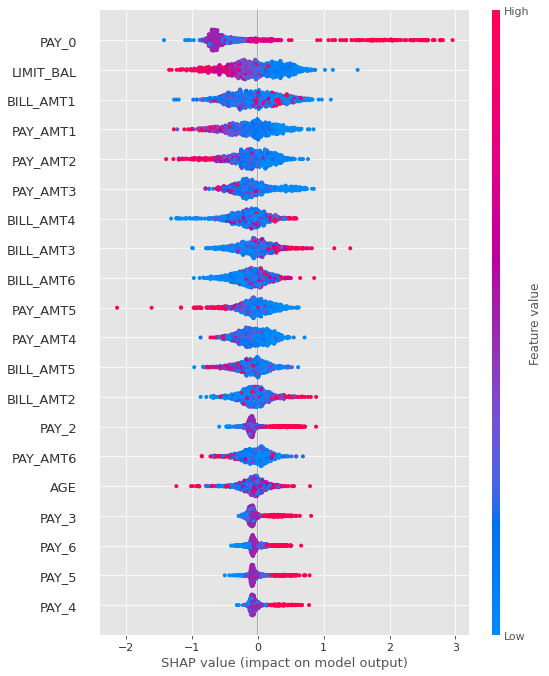

In [32]:
shap.summary_plot(shap_values, X_test[:1000])

**As you can see, the PAY_0 feature is the most significant and informative, the higher the value of this feature, the more likely it is that the model prediction will be 1. Features:**
* SEX
* EDUCATION 
* MARRIAGE 
* AGE 
* PAY_ATM3 
* PAY_ATM6 
* PAY_5 
* PAY_ATM5 
* PAY_ATM3

**were hardly used by the model, so they can be easily discarded if desired and retrained the model without losing quality**